### Libraries

In [1]:
from openai import OpenAI
import google.generativeai as genai

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import time
import os
import ast

### Layout

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_seq_items', None)

### General commands for getting response

In [3]:
def api_def(provider):
    # API keys are hidden in another file
    with open('api.txt', 'r', encoding='utf-8') as file:
        lines = [line.strip() for line in file.readlines()]

        # Different LLMs need different kinds of command
        if provider == 'chatgpt':
            client = OpenAI(api_key=str(lines[0]), base_url="https://api.openai.com/v1")
        
        elif provider == 'deepseek':
            client = OpenAI(api_key=str(lines[1]), base_url="https://api.deepseek.com")
        
        elif provider == 'gemini':
            genai.configure(api_key=str(lines[2]))

In [4]:
def get_completion(prompt, provider, model, temperature):
    messages = [{"role": "system", "content": "You are a research assistant conducting a systematic literature review on climate mobility. \
    Your task is to read the provided text and classify it according to the given properties with binary codes. \
    Do not include explanations, personal opinions or provide unrelated meta-comments in the answer. Provide only the classification results."},
               {"role": "user", "content": prompt}]

    # Different LLMs need different kinds of command
    if provider == 'gpt':
        api_def('chatgpt')
        response = client.responses.create(
            model=model,
            input=messages,
            temperature=temperature,
        )
        return response.output_text
        
    elif provider == 'ds':
        api_def('deepseek')
        response = client.responses.create(
            model=model,
            input=messages,
            temperature=temperature,
        )
        return response.output_text

    elif provider == 'gemini':
        api_def('gemini')
        model_gemini = genai.GenerativeModel(model)
        response = model_gemini.generate_content(
            prompt,
            generation_config={"temperature": temperature}
        )
        return response.text        

### Prompt and response processing

#### All together

In [6]:
CONTEXT = f"""
We are conducting a systematic review of climate mobility literature. For each paper, your task is to assign binary codes, namely '0' or '1', \
regarding many specific indices that I will provide. \
While reviewing a paper, please forget all the papers you have already coded, and please focus on this paper’s abstract, data/methods, results, \
and conclusions, rather than on 'introduction', 'state of the art', 'related works', 'motivation', etc. section since they may convey works of other \
research. Be careful not to wrongly consider such related works for coding a paper. \
Code it only with the indices I provide below, and do not provide additional explanations. Again, for each index, please only give one exact number, \
either '0' or '1', where '0' means 'No' (denotes 'this paper is not ...', or 'this paper doesn't consider...' etc.), while on the opposite '1' means 'Yes'.
"""

In [98]:
ZERO_SHOT_PROMPT = f"""

<Prof>: 
{CONTEXT} \n

Currently we have the following 36 indices: \n
a. The first 2 indices are about methods being used, namely qualitative and quantitative. Note that a paper can use mixed methods (both of them). \n
b. The following 2 indices are about data being included in the study, namely social-demographic-economic data and environmental data, \
note that a paper can contain both or neither of them. \n
c. Then there are 5 indices about focal demographic groups of the study, namely individual, households, subnational groups, national groups, \
international groups. Note that a paper can focus on diverse groups of people. And please don't misunderstand, this is not the focal geographic areas of a paper. \n
e. Indices 10 and 11 are about the type of places where related interviews of the study took place, namely urban and rural. A study may focus on both, or neither. \n
f. Indices 12 and 13 are about time being considered: time frame means the paper focuses on temporal issues with for example, time series analysis, \
and foresight means the paper talks about forecast, prediction or perspective. A paper may consider both or neither of them. \n
i: Indices 14-20 (7 indices) are about environmental stressors being considered in a study: 'Rainfall pattern / Variability', 'Temperature change', \
'Food scarcity / Famine / Food security', 'Drought / Aridity / Desertification', 'Floods', 'Erosion / Soil fertilty / Land degradation / Deforestation / Salinisation', \
'Self assessement / Perceived environment '. Note that the index 'self assessement or perception' is different from the other 6 indices about stressors. \
In other words, as long as data of those stressors are from human perception rather than observation, this index should have the value '1'.
About stressors, a paper can consider multiple or none of them. \n 
j: Indices 21-28 (8 indices) are about types of migration being included: 'Labour migration' (those related to work etc.), 'Marriage migration', \
'Refugees', 'International migration', 'Cross-border migration', 'Internal migration', 'Rural to urban' and 'Rural to rural'. Here 'cross border' usually \
means the migration from one nation to the adjacent nations, and 'international' leads to the migration with much longer distance. Note that a paper \
might contain multiple types of migration, and can contain none of them as well. \n
k: Indices 29-33 (5 indices) are about patterns of mobility or migration being included: 'Circular / Seasonal', 'Long distance', 'Short distance', \
'Temporal', and 'Permanent'. Note that a paper can also consider multiple or none of them. \n
l: The last 3 indices are about if specific demographic groups were focused on: 'Age', 'Gender', 'Ethnicity / Religion'. Note that a paper can also \
consider multiple or none of them. \n

Always keep the result in the following formality. Don't add anything else. \n
{{'Qualitative method': '_', 'Quantitative method': '_', 'Socio-demo-economic data': '_', 'Environmental data': '_', \
'Individuals': '_', 'Households': '_', 'Subnational groups': '_', 'National groups': '_', 'International groups': '_', \
'Urban': '_', 'Rural': '_', 'Time frame considered': '_', 'Foresight': '_', \
'Rainfall pattern / Variability': '_', 'Temperature change': '_', 'Food scarcity / Famine / Food security ': '_', 'Drought / Aridity / Desertification': '_', \
'Floods': '_', 'Erosion / Soil fertilty / Land degradation / Deforestation / Salinisation': '_', 'Self assessement / Perceived environment': '_', \
'Labour migration': '_', 'Marriage migration': '_', 'Refugees': '_', 'International migration': '_', 'Cross-border migration': '_', 'Internal migration': '_', \
'Rural to urban': '_', 'Rural to rural': '_', 'Circular / Seasonal': '_', 'Long distance': '_', 'Short distance': '_', 'Temporal': '_', 'Permanent': '_', \
'Age': '_', 'Gender': '_', 'Ethnicity / Religion': '_'}} \n

Here for each '_' there should be a binary code, either '0' or '1'. Again, do not put any other thing there. \
It's possible that some information is missing, for example, a paper may not mention the research method used in the research at all, in this case, \
you should just put '0' for both of these indices.
"""

In [99]:
FEW_SHOT_PROMPT = f"""

{ZERO_SHOT_PROMPT} \n

Now please try to categorize the following 3 paper chunks as an exercise: \n
\"\"\"{example}\"\"\"
\n
<research assistant> OK, here is my result: \n
{{'Qualitative method': '1', 'Quantitative method': '1', 'Socio-demo-economic data': '1', 'Environmental data': '1', \
'Individuals': '0', 'Households': '1', 'Subnational groups': '1', 'National groups': '0', 'International groups': '0', \
'Urban': '0', 'Rural': '1', 'Time frame considered': '1', 'Foresight': '0', \
'Rainfall pattern / Variability': '1', 'Temperature change': '0', 'Food scarcity / Famine / Food security ': '0', 'Drought / Aridity / Desertification': '1', \
'Floods': '1', 'Erosion / Soil fertilty / Land degradation / Deforestation / Salinisation': '1', 'Self assessement / Perceived environment': '1', \
'Labour migration': '1', 'Marriage migration': '0', 'Refugees': '0', 'International migration': '0', 'Cross-border migration': '0', 'Internal migration': '1', \
'Rural to urban': '1', 'Rural to rural': '0', 'Circular / Seasonal': '0', 'Long distance': '1', 'Short distance': '0', 'Temporal': '1', 'Permanent': '0', \
'Age': '1', 'Gender': '0', 'Ethnicity / Religion': '0'}}, \
{{'Qualitative method': '0', 'Quantitative method': '1', 'Socio-demo-economic data': '1', 'Environmental data': '1', \
'Individuals': '0', 'Households': '1', 'Subnational groups': '0', 'National groups': '0', 'International groups': '0', \
'Urban': '0', 'Rural': '1', 'Time frame considered': '1', 'Foresight': '1', \
'Rainfall pattern / Variability': '1', 'Temperature change': '1', 'Food scarcity / Famine / Food security ': '0', 'Drought / Aridity / Desertification': '0', \
'Floods': '0', 'Erosion / Soil fertilty / Land degradation / Deforestation / Salinisation': '0', 'Self assessement / Perceived environment': '0', \
'Labour migration': '0', 'Marriage migration': '0', 'Refugees': '0', 'International migration': '1', 'Cross-border migration': '0', 'Internal migration': '1', \
'Rural to urban': '1', 'Rural to rural': '0', 'Circular / Seasonal': '1', 'Long distance': '1', 'Short distance': '1', 'Temporal': '1', 'Permanent': '1', \
'Age': '0', 'Gender': '0', 'Ethnicity / Religion': '0'}}, \
{{'Qualitative method': '1', 'Quantitative method': '1', 'Socio-demo-economic data': '1', 'Environmental data': '1', \
'Individuals': '1', 'Households': '1', 'Subnational groups': '0', 'National groups': '0', 'International groups': '0', \
'Urban': '0', 'Rural': '1', 'Time frame considered': '1', 'Foresight': '0', \
'Rainfall pattern / Variability': '0', 'Temperature change': '0', 'Food scarcity / Famine / Food security ': '0', 'Drought / Aridity / Desertification': '0', \
'Floods': '0', 'Erosion / Soil fertilty / Land degradation / Deforestation / Salinisation': '1', 'Self assessement / Perceived environment': '0', \
'Labour migration': '1', 'Marriage migration': '1', 'Refugees': '0', 'International migration': '0', 'Cross-border migration': '0', 'Internal migration': '1', \
'Rural to urban': '1', 'Rural to rural': '0', 'Circular / Seasonal': '1', 'Long distance': '0', 'Short distance': '1', 'Temporal': '1', 'Permanent': '1', \
'Age': '1', 'Gender': '1', 'Ethnicity / Religion': '0'}}
"""

In [19]:
def extract_features(paper: dict, example: bool, provider, model, temperature):

    fail_count = 0
    while True:
        if example:
            prompt = f"""
            Please answer in a consistent style, performing the following actions step by step: \n
            1 - Read and understand the instructions and the examples, understand the professor's requirements and the research assistant's work on coding. \n
            2 - You will be provided with a paper. Please read and give your answer according to the professor's requirement \
            just as what the research assistant did. \n
            You just need to return the final result of step 2, and make it as Python dictionaty format as performed below. Do not explain reasoning. \n

            Here are the instructions and examples: \n"
            f"{FEW_SHOT_PROMPT}\n"
            Here is the new paper, please extract the required information like the research assistant: \n"
            f"{paper}\n"
            "Keep in mind that output format is Python dictionary, with no extra text."
            """

        elif not example:
            prompt = f"""
            Please answer in a consistent style, performing the following actions step by step: \n
            1 - Read and understand the instructions, understand the professor's requirements regarding coding. \n
            2 - You will be provided with a paper. Please read and give your answer according to the professor's requirement. \n
            You just need to return the final result of step 2, and make it as Python dictionaty format as performed below. Do not explain reasoning. \n

            Here are the instructions: \n"
            f"{ZERO_SHOT_PROMPT}\n"
            Here is the paper, please extract the required information: \n"
            f"{paper}\n"
            "Keep in mind that output format is Python dictionary, with no extra text."
            """

        response = get_completion(prompt, provider, model, temperature)
    
        if response.strip().startswith("```"):
            lines = response.splitlines()
            if lines and lines[0].startswith("```"):
                lines = lines[1:]
            if lines and lines[-1].startswith("```"):
                lines = lines[:-1]
            response = "\n".join(lines)
        response = response.strip()
    
        try:
            data = ast.literal_eval(response)
            return data, fail_count
        except Exception as e:
            fail_count += 1
            time.sleep(1)
            if fail_count >= 20:
                raise ValueError(f"Can't parse as Python dict: {response}, retried too many times") from e

    return data, fail_count

In [13]:
def extract_to_df(literature: dict, example: bool, provider, model):
    results = []
    time_list = []
    if provider == 'gemini':
        temperatures = np.round(np.arange(0.0, 1.0, 0.2), 1)
    else:
        temperatures = np.round(np.arange(0.0, 2.0, 0.4), 1)
        
    for t in temperatures:
        start_time = time.time()
        print (f"temperature:{t}")
        for run_id in range(20):
            success = False
            while not success:
                try:
                    features, fail = extract_features(literature, example, provider, model, t)
                    features["provider"] = provider
                    features["model"] = model
                    features["few shot"] = example
                    features["temperature"] = t
                    features["run"] = run_id
                    results.append(features)
                    success = True
                except (openai.error.RateLimitError,
                        openai.error.APIError,
                        openai.error.ServiceUnavailableError,
                        openai.error.Timeout) as e:
                    time.sleep(4)
        end_time = time.time()
        time_needed = end_time - start_time
        time_list.append(time_needed)


    df = pd.DataFrame(results)
    return df, fail, time_list

In [14]:
gpt_0, fail_gpt_0, t_gpt_0 = extract_to_df(literature[0], False, 'gpt', 'gpt-4o-mini')

temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6


In [20]:
gpt_3, fail_gpt_3, t_gpt_3 = extract_to_df(literature[0], True, 'gpt', 'gpt-4o-mini')

temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6


In [23]:
ds_0, fail_ds_0, t_ds_0 = extract_to_df(literature[0], False, 'ds', 'deepseek-chat')

temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6


In [27]:
ds_3, fail_ds_3, t_ds_3 = extract_to_df(literature[0], True, 'ds', 'deepseek-chat')

temperature:0.0
temperature:0.4
temperature:0.8
temperature:1.2
temperature:1.6


In [30]:
gemini_0, fail_gemini_0, t_gemini_0 = extract_to_df(literature[0], False, 'gemini', 'gemini-2.0-flash')

temperature:0.0
temperature:0.2
temperature:0.4
temperature:0.6
temperature:0.8


In [31]:
gemini_3, fail_gemini_3, t_gemini_3 = extract_to_df(literature[0], True, 'gemini', 'gemini-2.0-flash')

temperature:0.0
temperature:0.2
temperature:0.4
temperature:0.6
temperature:0.8


In [118]:
t_gemini_3

[69.41886234283447,
 78.68560218811035,
 95.0661997795105,
 97.76400184631348,
 54.96877384185791]

In [120]:
t_ds_3

[353.4693946838379,
 304.68881464004517,
 380.99885749816895,
 394.83893299102783,
 420.8543555736542]

In [66]:
df_all = pd.concat([gpt_0, gpt_3, ds_0, ds_3, gemini_0, gemini_3], ignore_index=True)
df_all = df_all.astype(str)

df_all = df_all.drop(columns=['Food scarcity / Famine / Food security'])
df_all.to_csv('bi_code_test.csv', index=False)

#### Evaluation

In [76]:
LLM_result = pd.read_csv('bi_code_test.csv')
manual_result = pd.read_excel('manual.xlsx')

In [77]:
manual_result = manual_result.drop(index=manual_result.index[0:3], columns=['ID', 'AUTHOR', 'TITLE']).reset_index(drop=True)
manual_result

,Qualitative method,Quantitative method,Socio-demo-economic data,Environmental data,Individuals,Households,Subnational groups,National groups,International groups,Urban,Rural,Time frame considered,Foresight,Rainfall pattern / Variability,Temperature change,Food scarcity / Famine / Food security,Drought / Aridity / Desertification,Floods,Erosion / Soil fertilty / Land degradation / Deforestation / Salinisation,Self assessement / Perceived environment,Labour migration,Marriage migration,Refugees,International migration,Cross-border migration,Internal migration,Rural to urban,Rural to rural,Circular / Seasonal,Long distance,Short distance,Temporal,Permanent,Age,Gender,Ethnicity / Religion
0,1,1,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,1,0,1,0,1,1,1,1,1,0


In [87]:
value_cols = manual_result.columns
model_cols_all = LLM_result.columns[36:]
model_cols = [c for c in model_cols_all if c != 'run']

model_acc_list = []

for _, model_row in LLM_result[model_cols].iterrows():
    mask = (LLM_result[model_cols] == model_row.values).all(axis=1)
    LLM_result_new = LLM_result.loc[mask, value_cols]

    col_acc = (LLM_result_new == manual_result.iloc[0]).mean(axis=0)
    final_acc = col_acc.mean()
    
    record = model_row.to_dict()
    record['accuracy'] = final_acc
    model_acc_list.append(record)

df_model_acc = pd.DataFrame(model_acc_list)

df_model_acc_avg = df_model_acc.groupby(['provider', 'model', 'few shot', 'temperature'], as_index=False)['accuracy'].mean()

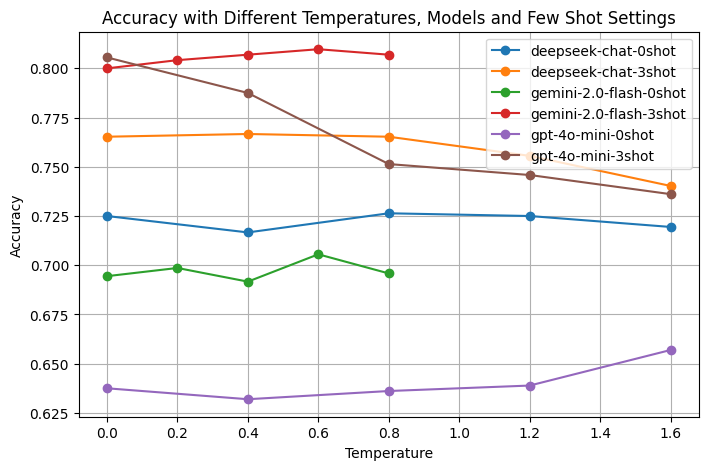

In [93]:
plt.figure(figsize=(8, 5))

for model in df_model_acc_avg['model'].unique():
    for few_shot in df_model_acc_avg['few shot'].unique():
        subset = df_model_acc_avg[(df_model_acc_avg['model'] == model) & (df_model_acc_avg['few shot'] == few_shot)]
        
        shot_label = '3shot' if few_shot else '0shot'
        label = f"{model}-{shot_label}"
        
        plt.plot(subset['temperature'], subset['accuracy'], marker='o', label=label)

plt.xlabel('Temperature')
plt.ylabel('Accuracy')
plt.title('Accuracy with Different Temperatures, Models and Few Shot Settings')
plt.legend()
plt.grid(True)
plt.show()

#### Separate

In [95]:
ZERO_SHOT_PROMPT_1 = f"""

<Prof>: 
{CONTEXT} \n

Currently we have the following 13 indices: \n
a. The first 2 indices are about methods being used, namely qualitative and quantitative. Note that a paper can use mixed methods (both of them). \n
b. The following 2 indices are about data being included in the study, namely social-demographic-economic data and environmental data, \
note that a paper can contain both or neither of them. \n
c. Then there are 5 indices about focal demographic groups of the study, namely individual, households, subnational groups, national groups, \
international groups. Note that a paper can focus on diverse groups of people. And please don't misunderstand, this is not the focal geographic areas of a paper. \n
e. Indices 10 and 11 are about the type of places where related interviews of the study took place, namely urban and rural. A study may focus on both, or neither. \n
f. Indices 12 and 13 are about time being considered: time frame means the paper focuses on temporal issues with for example, time series analysis, \
and foresight means the paper talks about forecast, prediction or perspective. A paper may consider both or neither of them. \n


Always keep the result in the following formality. Don't add anything else. \n
{{'Qualitative method': '_', 'Quantitative method': '_', 'Socio-demo-economic data': '_', 'Environmental data': '_', \
'Individuals': '_', 'Households': '_', 'Subnational groups': '_', 'National groups': '_', 'International groups': '_', \
'Urban': '_', 'Rural': '_', 'Time frame considered': '_', 'Foresight': '_'}} \n

Here for each '_' there should be a binary code, either '0' or '1'. Again, do not put any other thing there. \
It's possible that some information is missing, for example, a paper may not mention the research method used in the research at all, in this case, \
you should just put '0' for both of these indices.
"""

In [97]:
ZERO_SHOT_PROMPT_2 = f"""

<Prof>: 
{CONTEXT} \n

Currently we have the following 7 indices about environmental stressors being considered in a study: \n
'Rainfall pattern / Variability' (like the delay of rainy season, rather than floods or droughts), 'Temperature change', \
'Food scarcity / Famine / Food security', 'Drought / Aridity / Desertification', 'Floods', \
'Erosion / Soil fertilty / Land degradation / Deforestation / Salinisation', 'Self assessement / Perceived environment'. \
Note that the index 'self assessement or perception' is different from the other 6 indices about stressors. \
In other words, as long as data of those stressors are from human perception rather than observation, this index should have the value '1'.
About stressors, a paper can consider multiple or none of them. \n 

Always keep the result in the following formality. Don't add anything else. \n
{{'Rainfall pattern / Varibility': '_', 'Temperature change': '_', 'Food scarcity / Famine / Food security ': '_', 'Drought / Aridity / Desertification': '_', \
'Floods': '_', 'Erosion / Soil fertilty / Land degradation / Deforestation / Salinisation': '_', 'Self assessement / Perceived environment': '_'}} \n

Here for each '_' there should be a binary code, either '0' or '1'. Again, do not put any other thing there. \
It's possible that some information is missing, for example, a paper may not mention any environmental stressors specifically, in this case, \
you should just put '0' for both of these indices.
"""

In [100]:
ZERO_SHOT_PROMPT_3 = f"""

<Prof>: 
{CONTEXT} \n

Currently we have the following 8 indices about types of migration being included: \n
'Labour migration' (those related to work etc.), 'Marriage migration', \
'Refugees', 'International migration', 'Cross-border migration', 'Internal migration', 'Rural to urban' and 'Rural to rural'. Here 'cross border' usually \
means the migration from one nation to the adjacent nations, and 'international' leads to the migration with much longer distance. Note that a paper \
might contain multiple types of migration, and can contain none of them as well. \n

Always keep the result in the following formality. Don't add anything else. \n
{{'Labour migration': '_', 'Marriage migration': '_', 'Refugees': '_', 'International migration': '_', 'Cross-border migration': '_', 'Internal migration': '_', \
'Rural to urban': '_', 'Rural to rural': '_'}} \n

Here for each '_' there should be a binary code, either '0' or '1'. Again, do not put any other thing there. \
It's possible that some information is missing, for example, a paper may not mention specific migration types at all, in this case, \
you should just put '0' for both of these indices.
"""

In [102]:
ZERO_SHOT_PROMPT_4 = f"""

<Prof>: 
{CONTEXT} \n

Currently we have the following 5 indices about patterns of migration being included: \n
'Circular / Seasonal', 'Long distance', 'Short distance', 'Temporal', and 'Permanent'. Note that a paper can also consider multiple or none of them. \n

Always keep the result in the following formality. Don't add anything else. \n
{{'Circular / Seasonal': '_', 'Long distance': '_', 'Short distance': '_', 'Temporal': '_', 'Permanent': '_'}} \n

Here for each '_' there should be a binary code, either '0' or '1'. Again, do not put any other thing there. \
It's possible that some information is missing, for example, a paper may not mention the research method used in the research at all, in this case, \
you should just put '0' for both of these indices.
"""

In [103]:
ZERO_SHOT_PROMPT_5 = f"""

<Prof>: 
{CONTEXT} \n

Currently we have the following 3 indices about if specific demographic groups were focused on: \n
'Age', 'Gender', 'Ethnicity / Religion'. Note that a paper can also consider multiple or none of them. \n

Always keep the result in the following formality. Don't add anything else. \n
{{'Age': '_', 'Gender': '_', 'Ethnicity / Religion': '_'}} \n

Here for each '_' there should be a binary code, either '0' or '1'. Again, do not put any other thing there. \
It's possible that some information is missing, for example, a paper may not mention the research method used in the research at all, in this case, \
you should just put '0' for both of these indices.
"""

In [104]:
def extract_features_sep(paper: dict, example: bool, provider, model, temperature, part):

    fail_count = 0
    ZERO_SHOT_PROMPT_CURRENT = globals()[f"ZERO_SHOT_PROMPT_{part}"]
    FEW_SHOT_PROMPT_CURRENT = globals()[f"ZERO_SHOT_PROMPT_{part}"]
    while True:
        if example:
            prompt = f"""
            Please answer in a consistent style, performing the following actions step by step: \n
            1 - Read and understand the instructions and the examples, understand the professor's requirements and the research assistant's work on coding. \n
            2 - You will be provided with a paper. Please read and give your answer according to the professor's requirement \
            just as what the research assistant did. \n
            You just need to return the final result of step 2, and make it as Python dictionaty format as performed below. Do not explain reasoning. \n

            Here are the instructions and examples: \n"
            f"{FEW_SHOT_PROMPT_CURRENT}\n"
            Here is the new paper, please extract the required information like the research assistant: \n"
            f"{paper}\n"
            "Keep in mind that output format is Python dictionary, with no extra text."
            """

        elif not example:
            prompt = f"""
            Please answer in a consistent style, performing the following actions step by step: \n
            1 - Read and understand the instructions, understand the professor's requirements regarding coding. \n
            2 - You will be provided with a paper. Please read and give your answer according to the professor's requirement. \n
            You just need to return the final result of step 2, and make it as Python dictionaty format as performed below. Do not explain reasoning. \n

            Here are the instructions: \n"
            f"{ZERO_SHOT_PROMPT_CURRENT}\n"
            Here is the paper, please extract the required information: \n"
            f"{paper}\n"
            "Keep in mind that output format is Python dictionary, with no extra text."
            """

        response = get_completion(prompt, provider, model, temperature)
    
        if response.strip().startswith("```"):
            lines = response.splitlines()
            if lines and lines[0].startswith("```"):
                lines = lines[1:]
            if lines and lines[-1].startswith("```"):
                lines = lines[:-1]
            response = "\n".join(lines)
        response = response.strip()
    
        try:
            data = ast.literal_eval(response)
            return data, fail_count
        except Exception as e:
            fail_count += 1
            time.sleep(1)
            if fail_count >= 20:
                raise ValueError(f"Can't parse as Python dict: {response}, retried too many times") from e

    return data, fail_count

In [115]:
def extract_to_df_sep(literature: dict, example: bool, provider, model, part):
    results = []
    if provider == 'gemini':
        temperatures = np.round(np.arange(0.0, 1.0, 0.2), 1)
    else:
        temperatures = np.round(np.arange(0.0, 2.0, 0.4), 1)
        
    for t in temperatures:
        print (f"temperature:{t}")
        for run_id in range(20):
            success = False
            while not success:
                try:
                    features, _ = extract_features_sep(literature, example, provider, model, t, part)
                    features["provider"] = provider
                    features["model"] = model
                    features["few shot"] = example
                    features["temperature"] = t
                    features["run"] = run_id
                    results.append(features)
                    success = True
                except (openai.error.RateLimitError,
                        openai.error.APIError,
                        openai.error.ServiceUnavailableError,
                        openai.error.Timeout) as e:
                    time.sleep(4)


    df = pd.DataFrame(results)
    return df

In [111]:
def concat(literature: dict, example: bool, provider, model):
    dfs = {}
    for part in range(1,6):
        dfs[f"df_{part}"] = extract_to_df_sep(literature, example, provider, model, part)

    merged_df = pd.merge(dfs["df_1"], 
                         pd.merge(dfs["df_2"],
                                  pd.merge(dfs["df_3"],
                                           pd.merge(dfs["df_4"], dfs["df_5"], on=['provider', 'model', 'few shot', 'temperature', 'run'], how='inner'),
                                           on=['provider', 'model', 'few shot', 'temperature', 'run'], how='inner'),
                                  on=['provider', 'model', 'few shot', 'temperature', 'run'], how='inner'),
                         on=['provider', 'model', 'few shot', 'temperature', 'run'], how='inner')
    return merged_df

In [116]:
gemini_0_sep = concat(literature[0], False, 'gemini', 'gemini-2.0-flash')

temperature:0.0
temperature:0.2
temperature:0.4
temperature:0.6
temperature:0.8
temperature:0.0
temperature:0.2
temperature:0.4
temperature:0.6
temperature:0.8
temperature:0.0
temperature:0.2
temperature:0.4
temperature:0.6
temperature:0.8
temperature:0.0
temperature:0.2
temperature:0.4
temperature:0.6
temperature:0.8
temperature:0.0
temperature:0.2
temperature:0.4
temperature:0.6
temperature:0.8
